# debug.ComputeFractions

In [1]:
import numpy as np
import pandas as pd
import astropy.io.ascii as at

In [137]:
from file_loc import FileLocs
from utils import check_non_valid_number

fl = FileLocs()
galaxy_file = fl.gal_fname1
outfile_base = fl.data_loc+'tmp/{label}_{var}.npy'

print('--------Initial Files-------')
print('Galaxy File : %s' % galaxy_file)
print()

# load catalogs
gal0 = at.read(galaxy_file)

mask = np.abs(gal0['vlosn']) <= 3.
mask &= gal0['ssfr']>=-20
gal = gal0[mask].copy()

print('Seting Variables')
print()
gid = np.array(gal['Yang'])

rn = np.array(gal['Rn'])
mass = np.array(gal['mass'])
t_infall = np.array(gal['t_infall'])/1e9
morph_type = np.array(gal['TType'])
ssfr = np.array(gal['ssfr'])
# sfr classification
sf   = np.array(gal['SF']).astype(int)
qf   = (1-sf).astype(int)

# morphological classification
sp   = np.where(gal['TType'] > 0, 1, 0).astype(int)
ell  = np.where(gal['TType'] <=0, 1, 0).astype(int)
s0   = check_non_valid_number(gal['PS0'])
bulge= check_non_valid_number(gal['Pbulge'])
disk = check_non_valid_number(gal['Pdisk'])
bar  = check_non_valid_number(gal['PbarGZ2'])
merger= check_non_valid_number(gal['Pmerg'])

Pi   = np.array(gal['pinfall'])
Po   = np.array(gal['porbital'])
Pn   = np.array(gal['pinterloper'])
m200 = np.array(gal['M200'])

Pn = np.where(gal['Rn']<=0.5,0.,Pn)

--------Initial Files-------
Galaxy File : ../data/groups_deCarvalho2017_galaxies_final_flag_johnnyheq_volumeLimited_v1.csv

Seting Variables



In [138]:
import matplotlib.pyplot as plt

In [139]:
def plot_profile(x,frac,**args):
    ymed = np.median(frac,axis=1)
    error_low = ymed-np.percentile(frac,16,axis=1)
    error_high = np.percentile(frac,84,axis=1)-ymed
    plt.errorbar(x,np.median(frac,axis=1),yerr=np.vstack([error_low, error_high]),**args)

In [140]:
import sys
sys.path.append('/Users/jesteves/Documents/GitHub/galaxyFormation/scripts/')

from compute_fractions import computeFraction


In [141]:
msbins = np.arange(9.0,12.50,0.1)
rbins = np.arange(0.,3.3,0.3)
tbins = np.logspace(8.2,11.2,11)/1e9/2.   #infall time
mrpbins = np.linspace(-3.,7.,11)

In [142]:
q = computeFraction('quenching',path=fl.data_loc)
q.add_probabilities(qf,Po,Pi,Pn)
q.run('smass',mass,msbins,write=True,nBootStrap=500)
q.run('cross_time',t_infall,tbins,write=True,nBootStrap=500)
q.run('radii',rn,rbins,write=True,nBootStrap=500)
q.run('ttype',morph_type,mrpbins,write=True,nBootStrap=500)

Welcome to our cluster enviromental effects tools
probablity: quenching


/Users/jesteves/Documents/GitHub/galaxyFormation/scripts/compute_fractions.py:81: RuntimeWarning: invalid value encountered in double_scalars
  frac = N1/N2
/Users/jesteves/Documents/GitHub/galaxyFormation/scripts/compute_fractions.py:88: RuntimeWarning: invalid value encountered in true_divide
  qfe = dfrac/(1-fq1)
/Users/jesteves/Documents/GitHub/galaxyFormation/scripts/compute_fractions.py:88: RuntimeWarning: divide by zero encountered in true_divide
  qfe = dfrac/(1-fq1)
/usr/local/anaconda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/usr/local/anaconda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [110]:
# ## quenching fraction

# plot_profile(q.xmed,q.qfrac1,label='Orbital+Infall')
# plot_profile(q.xmed,q.qfrac2,label='Orbital+Interlopers')
# plot_profile(q.xmed,q.qfrac3,label='Infall+Interlopers')
# plt.legend(fontsize=14)

In [111]:
# x = np.loadtxt(file_base.format(xlabel='radii', name='quenching')).T

In [112]:
file_base = fl.data_loc+'/tmp/{xlabel}_{name}.npy'

In [113]:
label1 = ['Orbital', 'Infall', 'Interlopers']
label2 = ['Orbita-Infall', 'Orbital-Interlopers', 'Infall-Interlopers']

def get_percentile(y):
    a1,a2,a3 = np.nanpercentile(y,[25,50,75])
    ylow,yhig = a1-3.*(a3-a1)/2.,a3+3.*(a3-a1)/2.
    return ylow,yhig


def plot_fraction_pannel(xlabel, name, xscale=False, save=None):
    if xlabel=='cross_time':
        xscale = True

    x = np.loadtxt(file_base.format(xlabel=xlabel, name=name)).T
    
    plt.clf()
    fig = plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    
    count = np.zeros_like(x[0])
    for i in range(3):
        ii = 3*i + 1
        plt.errorbar(x[0], x[ii], yerr=np.vstack([x[ii+1],x[ii+2]]), label=label1[i], fmt='o')
    
    if xscale:
        plt.xscale('log')
    plt.legend(fontsize=12)
    
    #plt.xlabel(r'Log($M_\star/M_{\odot}$)',fontsize=16)
    plt.title('%s Fraction'%name,fontsize=16)
    
    plt.subplot(1, 2, 2)
    
    y = np.empty((0))
    for i in range(3):
        ii = (3*i + 1)+9
        x[ii] = np.where(x[ii]<-.75,np.nan,x[ii])
        plt.errorbar(x[0], x[ii], yerr=np.vstack([x[ii+1],x[ii+2]]), label=label2[i], fmt='o')
        y = np.hstack([y,x[ii]])
    
    #plt.xlabel(r'Log($M_\star/M_{\odot}$)',fontsize=18)
    plt.legend()
    plt.title('%s Fraction Excess'%name,fontsize=16)
    if xscale:
        plt.xscale('log')
    del x
    
    if save is not None:
        plt.savefig(save, transparent=False)
        plt.clf()

<Figure size 432x288 with 0 Axes>

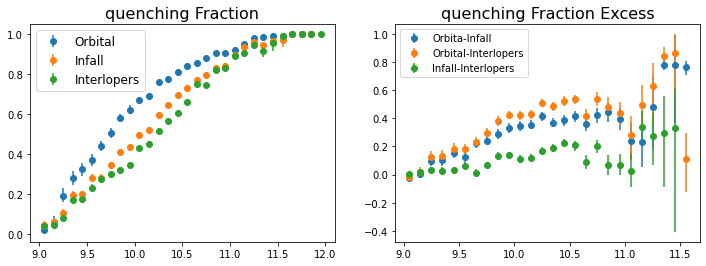

In [114]:
plot_fraction_pannel('smass','quenching')

<Figure size 432x288 with 0 Axes>

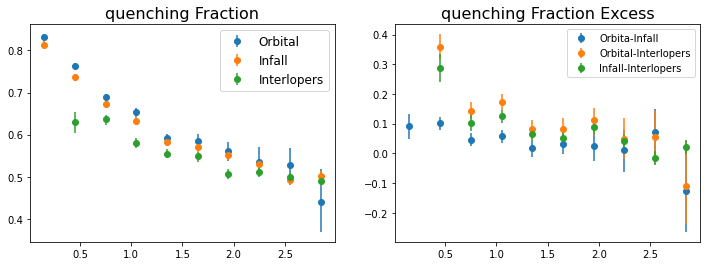

In [115]:
plot_fraction_pannel('radii','quenching')

<Figure size 432x288 with 0 Axes>

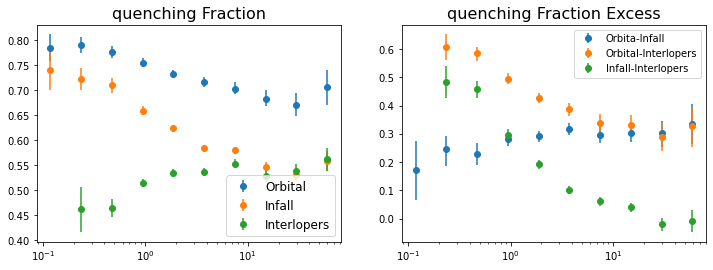

In [116]:
plot_fraction_pannel('cross_time','quenching')

<Figure size 432x288 with 0 Axes>

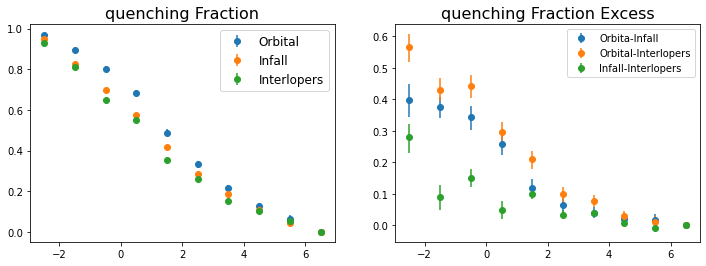

In [123]:
plot_fraction_pannel('ttype','quenching')

In [45]:
x = np.loadtxt(file_base.format(xlabel='radii', name='quenching')).T

array([0.00871, 0.00645, 0.00802, 0.01109, 0.01075, 0.01309, 0.01848,
       0.02482, 0.03778, 0.0378 , 0.05086, 0.08892])

In [82]:
q = computeFraction('elliptical',path=fl.data_loc)
q.add_probabilities(ell,Po,Pi,Pn)
q.run('smass',mass,msbins,write=True,nBootStrap=500)
q.run('cross_time',t_infall,tbins,write=True,nBootStrap=500)
q.run('radii',rn,rbins,write=True,nBootStrap=500)

Welcome to our cluster enviromental effects tools
probablity: elliptical


/Users/jesteves/Documents/GitHub/galaxyFormation/scripts/compute_fractions.py:81: RuntimeWarning: invalid value encountered in double_scalars
  frac = N1/N2
/Users/jesteves/Documents/GitHub/galaxyFormation/scripts/compute_fractions.py:88: RuntimeWarning: invalid value encountered in true_divide
  qfe = dfrac/(1-fq1)
/Users/jesteves/Documents/GitHub/galaxyFormation/scripts/compute_fractions.py:88: RuntimeWarning: divide by zero encountered in true_divide
  qfe = dfrac/(1-fq1)
/usr/local/anaconda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/usr/local/anaconda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


<Figure size 432x288 with 0 Axes>

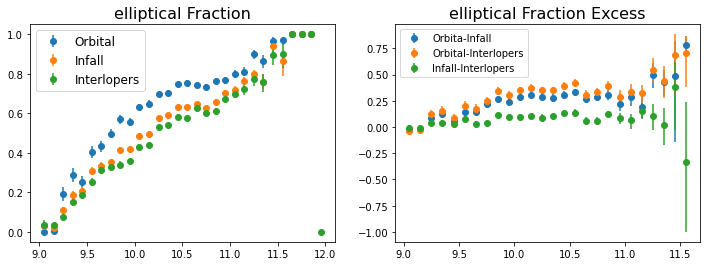

In [83]:
plot_fraction_pannel('smass','elliptical')

<Figure size 432x288 with 0 Axes>

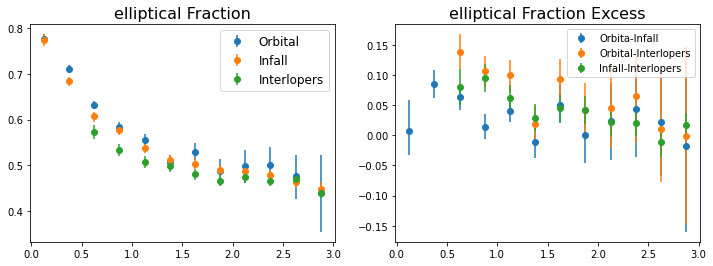

In [84]:
plot_fraction_pannel('radii','elliptical')

<Figure size 432x288 with 0 Axes>

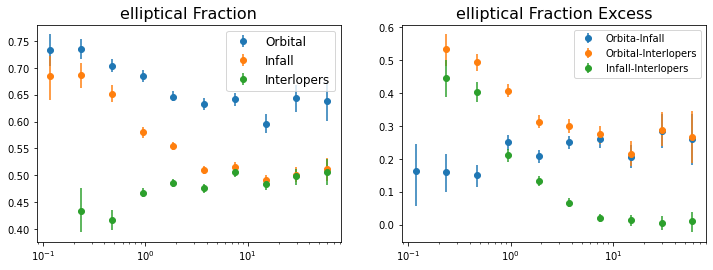

In [85]:
plot_fraction_pannel('cross_time','elliptical')

In [175]:
q = computeFraction('bulge',path=fl.data_loc)
q.add_probabilities(bulge,Po,Pi,Pn)
q.run('smass',mass,msbins,write=True,nBootStrap=500)
q.run('cross_time',t_infall,tbins,write=True,nBootStrap=500)
q.run('radii',rn,rbins,write=True,nBootStrap=500)

Welcome to our cluster enviromental effects tools
probablity: bulge


/Users/jesteves/Documents/GitHub/galaxyFormation/scripts/compute_fractions.py:81: RuntimeWarning: invalid value encountered in double_scalars
  frac = N1/N2
/usr/local/anaconda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/usr/local/anaconda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


<Figure size 432x288 with 0 Axes>

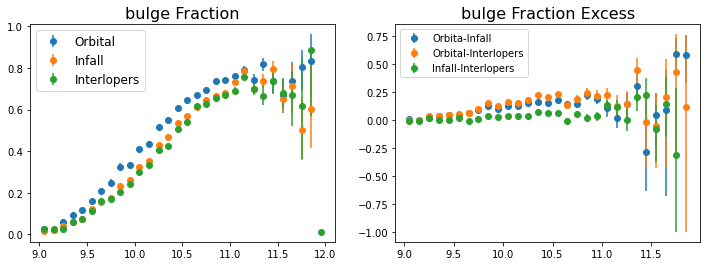

In [176]:
plot_fraction_pannel('smass','bulge')

<Figure size 432x288 with 0 Axes>

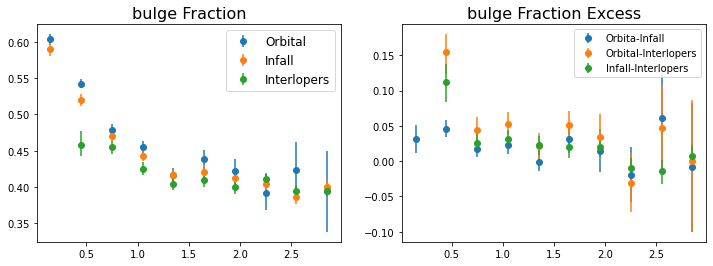

In [177]:
plot_fraction_pannel('radii','bulge')

<Figure size 432x288 with 0 Axes>

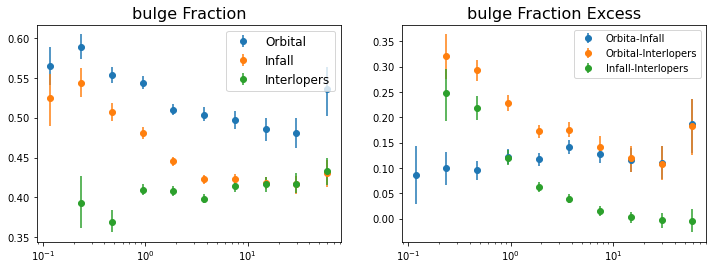

In [178]:
plot_fraction_pannel('cross_time','bulge')

In [94]:
msbins2 = np.arange(9.0,11.5,0.25)

In [95]:
q = computeFraction('spiral',path=fl.data_loc)
q.add_probabilities(sp,Po,Pi,Pn)
q.run('smass',mass,msbins,write=True,nBootStrap=500)
q.run('cross_time',t_infall,tbins,write=True,nBootStrap=500)
q.run('radii',rn,rbins,write=True,nBootStrap=500)

Welcome to our cluster enviromental effects tools
probablity: spiral


<Figure size 432x288 with 0 Axes>

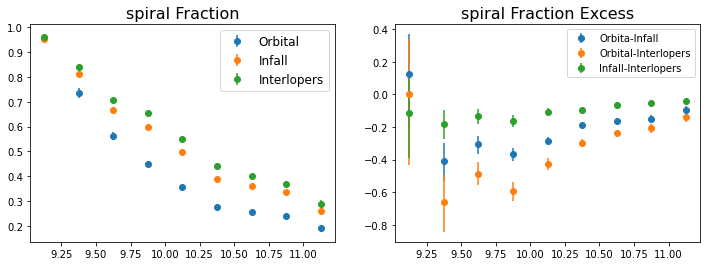

In [96]:
plot_fraction_pannel('smass','spiral')

<Figure size 432x288 with 0 Axes>

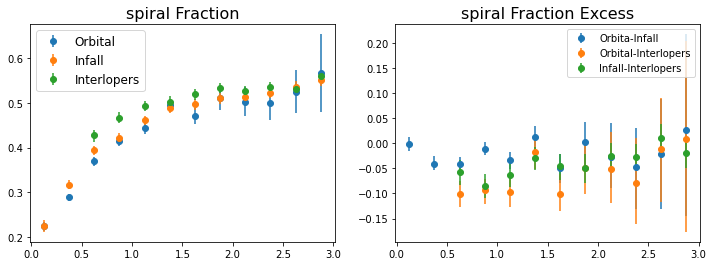

In [97]:
plot_fraction_pannel('radii','spiral')

<Figure size 432x288 with 0 Axes>

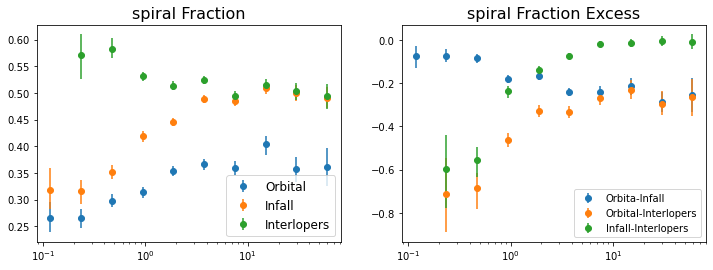

In [98]:
plot_fraction_pannel('cross_time','spiral')

In [143]:
np.count_nonzero(ssfr<-100)

0

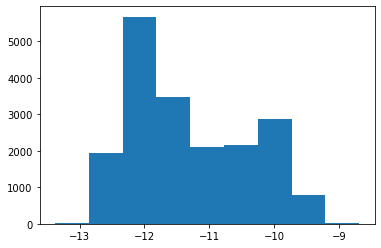

In [160]:
n,ssfrbins,_ = plt.hist(ssfr,weights=Po+Pi,bins=9)

In [161]:
ssfrbins

array([-13.3791    , -12.85838156, -12.33766311, -11.81694467,
       -11.29622622, -10.77550778, -10.25478933,  -9.73407089,
        -9.21335244,  -8.692634  ])